# Single Timepoint Processing
This notebook is here to establish a way of working with timelapse data downloaded in a previous notebook. We will be developing a workflow which can later be used on all timepoints to retrieve the labelimages as well as the measurements for all timepoints. To speed up the processing we will base the workflow of [pyclesperanto]().

In [1]:
import napari_clusters_plotter as ncp
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
import napari

The image we are working on is at an early stage of gastrulation, where the posterior pit has formed (top of the image). This is a good image to work on as it has nuclei which can be identified clearly across the whole embryo.

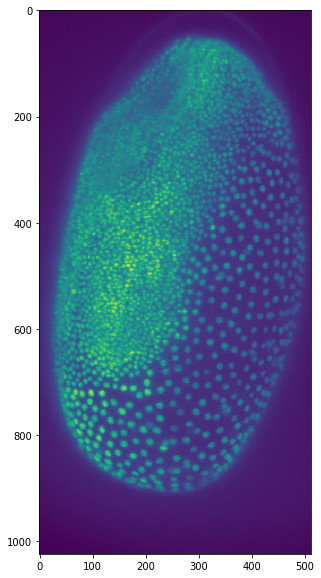

In [2]:
%matplotlib inline
tribolium = imread('lund_i000217_oi_001007.tif')
plt.figure(figsize=(10,10))
cle.imshow(tribolium)

The first step to actually processing the images is taking care of the anisotropic pixels by rescaling the images. Here I am experimenting with different methods of rescaling. One way will keep the original amount of x and y pixels and the other will downscale the x and y pixels (since the pixel size is below 1): 

In [3]:
def resample_isotropic_nodownsample(image_3d,voxelsize_zyx):
    import numpy as np
    import pyclesperanto_prototype as cle
    # we need to select a powerful GPU for this
    cle.select_device("GTX")
    if voxelsize_zyx[2] == voxelsize_zyx[1]:
        voxelsize_zyx = np.array(voxelsize_zyx)
        norm_voxelsize = voxelsize_zyx/voxelsize_zyx[2]
        input_image = cle.push_zyx(image_3d)
        resampled_image = cle.resample(input_image, factor_x=norm_voxelsize[2], 
                                       factor_y=norm_voxelsize[1], factor_z=norm_voxelsize[0])
        image_array = cle.pull_zyx(resampled_image)
        return image_array

voxel_size_zyx = [3.0, 0.6934, 0.6934]
resampled_tribolium_no_downscale = resample_isotropic_nodownsample(cle.push(tribolium), voxel_size_zyx)
print('without downscaling shape is {}'.format(resampled_tribolium_no_downscale.shape))

resampled_tribolium = cle.pull(cle.resample(cle.push(tribolium), 
                                            factor_x=voxel_size_zyx[2], 
                                            factor_y=voxel_size_zyx[1], 
                                            factor_z=voxel_size_zyx[0])
                               )
print('with downscaling shape is {}'.format(resampled_tribolium.shape))

without downscaling shape is (307, 1024, 512)
with downscaling shape is (213, 710, 355)


The image dimensions increase a lot when rescaling without downscaling in the x and y dimension. In order to save some space and processing time we will accept this decrease in image quality as we want to keep the workflow simpler and faster. This is a point to debate though.

In [4]:
# This workflow does a good job of approximating cellular regions around the nuclei
def workflow(image, number_of_dilations = 10, number_of_erosions = 4):
    import numpy as np
    import pyclesperanto_prototype as cle    

    gpu_input = cle.push(image)

    # Spot detection
    # After some noise removal/smoothing, we perform a local maximum detection

    # gaussian blur -> needs adjusting, maybe even other filters for preprocessing
    gpu_tophat = cle.top_hat_sphere(gpu_input,radius_x=7, radius_y=7, radius_z=7)
    gpu_blurred = cle.gaussian_blur(gpu_tophat, sigma_x=1, sigma_y=1, sigma_z=2) 
    gpu_input = None
    # detect maxima: instead of a pointslist we get and image with white pixels at the maxima locations
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    gpu_tophat = None
    # Spot curation
    # Now, we remove spots with values below a certain intensity and label the remaining spots

    # threshold
    gpu_thresholded = cle.threshold_otsu(gpu_blurred)
    gpu_blurred = None

    # mask
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)
    gpu_detected_maxima = None
    gpu_thresholded = None
    # label spots
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    gpu_masked_spots = None
    
    number_of_spots = cle.maximum_of_all_pixels(gpu_labelled_spots)
    print("Number of detected spots: " + str(number_of_spots))
    # retrieve the image to take a look at the maxima in napari
    # label map closing

    flip = cle.create_like(gpu_labelled_spots)
    flop = cle.create_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
    
    gpu_labelled_spots = None
    
    flap = cle.greater_constant(flip, constant= 1)

    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_sphere(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    flip = None
    flop = None
    flap = None
    flag = None
    
    alllabels = cle.close_index_gaps_in_label_map(gpu_labels)
    output = cle.pull(alllabels)
    print('Label Numbering Starts at {val}'.format(val = np.min(output[np.nonzero(output)])))
    print('Workflow Completed')
    return output

labels = workflow(resampled_tribolium)

Number of detected spots: 2496.0
Label Numbering Starts at 1
Workflow Completed


The workflow above was adapted from Robert Haase (link or citation) and does not take long to process the image. We can take a quick first look at the result below in a maximum projection:

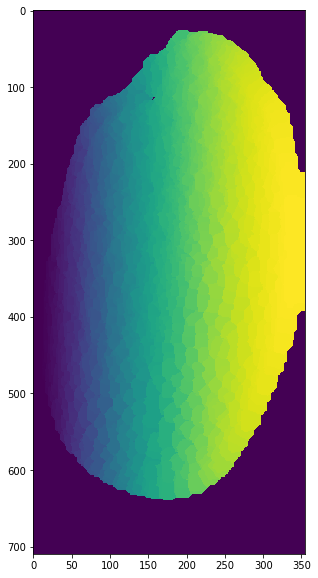

In [5]:
plt.figure(figsize=(10,10))
cle.imshow(labels)

Now let's look at the labels in 3D to get a better view:

In [6]:
import napari
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(resampled_tribolium)
viewer.add_labels(labels)

['napari.types.LabelsData', 'napari.types.ImageData', 'int', 'float', 'str', 'bool', 'napari.viewer.Viewer', 'napari.Viewer', "<class 'napari.types.LabelsData'>", "<class 'napari.types.ImageData'>", "<class 'int'>", "<class 'float'>", "<class 'str'>", "<class 'bool'>", "<class 'napari.viewer.Viewer'>", "<class 'napari.Viewer'>"]


C:\Users\ryans\anaconda3\envs\ncp_dev_v1\lib\site-packages\napari\plugins\_plugin_manager.py:494: UserWarning: Plugin 'napari-accelerated-pixel-and-object-classification' provided a non-callable type to `napari_experimental_provide_function`: <class 'magicgui._magicgui.MagicFactory'>. Function widget ignored.
  warn(message=warn_message)


<Labels layer 'labels' at 0x2130e28e0a0>

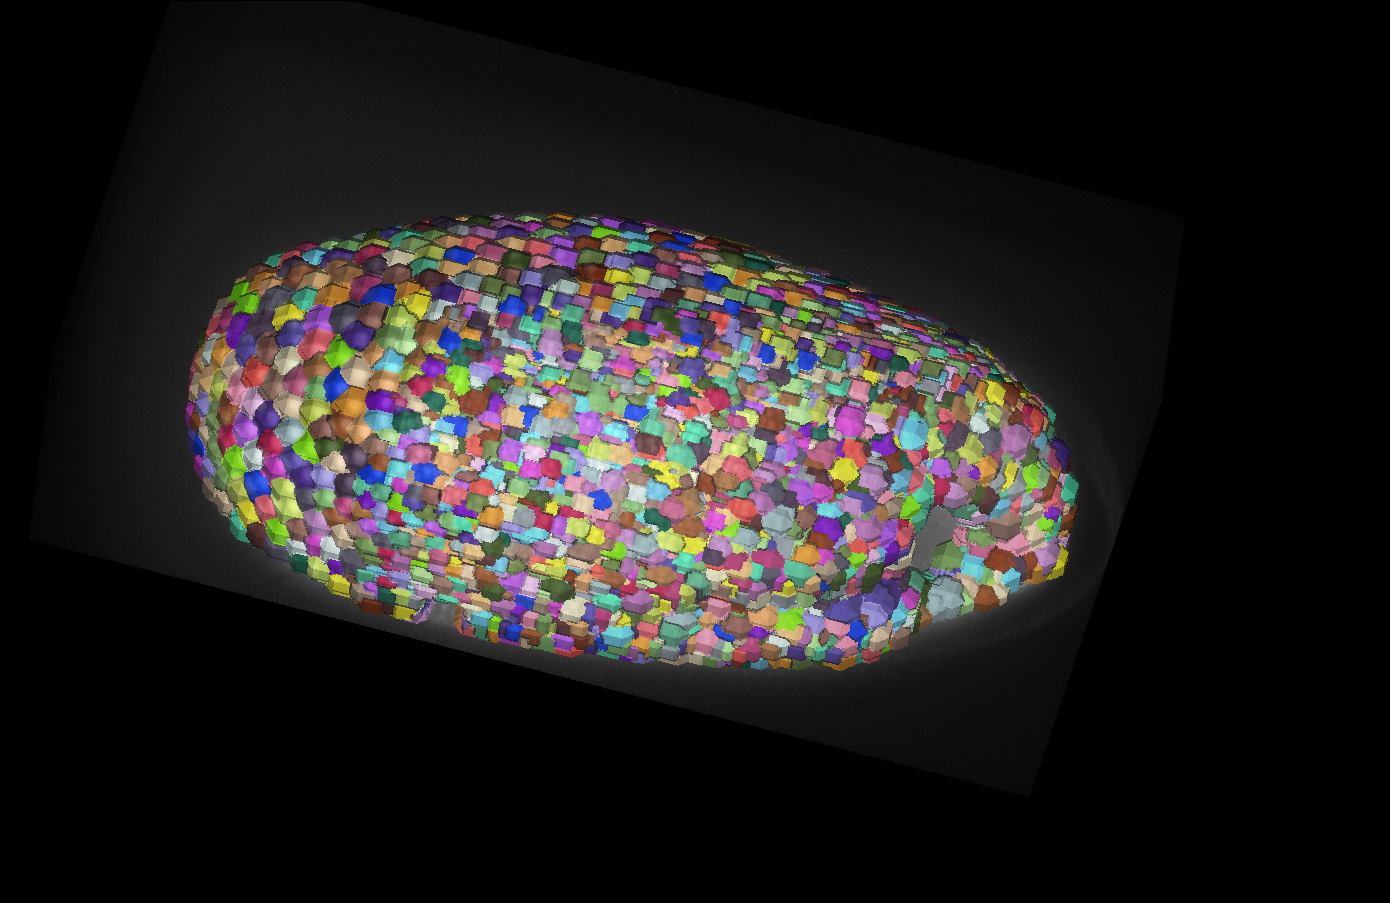

In [7]:
napari.utils.nbscreenshot(viewer=viewer, canvas_only=True)

although slightly more pixelated I think we can work with this segmentation for a proof of concept implementation. Now only the measuring of properties of the cells is left to figure out.

The functions for measuring the  regionproperties can be used directly from the napari cluster plotter to retrieve the data:

In [8]:
from napari_clusters_plotter._measure import get_regprops_from_regprops_source

region_properties = pd.DataFrame(get_regprops_from_regprops_source(intensity_image = resampled_tribolium, 
                                                                   label_image = labels, 
                                                                   region_props_source = 'neighborhood', 
                                                                   n_closest_points_list= [2,3,4]))
region_properties

Measurements Completed.


,label,min_intensity,max_intensity,sum_intensity,area,mean_intensity,centroid_x,centroid_y,centroid_z,mean_distance_to_centroid,standard_deviation_intensity,max_distance_to_centroid,mean_max_distance_to_centroid_ratio,avg distance of 2 closest points,avg distance of 3 closest points,avg distance of 4 closest points,touching neighbor count
0,1,253.0,627.0,1292246.0,3601.0,358.857513,21.215218,470.926392,4.133852,8.414832,63.419624,18.140446,2.155770,11.488474,12.689662,14.350519,5.0
1,2,267.0,665.0,753672.0,1859.0,405.417938,18.513178,393.976318,21.324905,6.491931,98.944504,14.016012,2.158990,8.780050,9.656013,10.570363,8.0
2,3,280.0,552.0,236518.0,599.0,394.854736,19.459099,404.729523,13.532554,5.607751,62.999672,13.225286,2.358394,12.023585,12.242212,12.510012,5.0
3,4,312.0,482.0,118075.0,307.0,384.609131,28.918568,412.175903,1.283388,6.119848,38.973103,14.588069,2.383730,13.551344,15.334044,16.546541,3.0
4,5,301.0,424.0,149967.0,411.0,364.883209,26.948904,434.934296,8.956204,6.330723,26.596672,18.567921,2.932986,7.986496,9.668428,10.618778,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,2490,174.0,467.0,2795136.0,11123.0,251.293365,342.253998,274.602081,18.653782,10.949775,36.833023,20.439627,1.866671,18.091942,19.200096,20.110455,5.0
2490,2491,190.0,444.0,2032858.0,7775.0,261.460846,344.195892,290.508301,12.908296,10.000325,38.840260,20.383915,2.038325,15.828430,16.547173,17.738293,5.0
2491,2492,191.0,392.0,2189242.0,8755.0,250.056183,342.791412,342.575653,7.316733,10.162822,27.521301,19.413149,1.910213,19.878868,20.284500,21.752792,4.0
2492,2493,202.0,501.0,1669735.0,6100.0,273.727051,343.893768,307.767059,7.859344,9.127412,43.218037,18.799923,2.059721,16.251362,16.829128,18.118649,4.0
